# 1.) Import the data from CCLE into a new Google Colab file

In [1]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [3]:
df=pd.read_csv("/content/gdrive/MyDrive/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.loc[df["smoker"]=="yes","smoker"]=1
df.loc[df["smoker"]=="no","smoker"]=0

In [5]:
df.loc[df["sex"]=="female","sex"]=1
df.loc[df["sex"]=="male","sex"]=0

In [6]:
df["region1"]=df["region"]
df["region2"]=df["region"]
df["region3"]=df["region"]
df["region4"]=df["region"]


df.loc[df['region']=='southwest','region1']=1
df.loc[df['region']=='northwest','region1']=0
df.loc[df['region']=='southeast','region1']=0
df.loc[df['region']=='northeast','region1']=0

df.loc[df['region']=='southwest','region2']=0
df.loc[df['region']=='northwest','region2']=1
df.loc[df['region']=='southeast','region2']=0
df.loc[df['region']=='northeast','region2']=0

df.loc[df['region']=='southwest','region3']=0
df.loc[df['region']=='northwest','region3']=0
df.loc[df['region']=='southeast','region3']=1
df.loc[df['region']=='northeast','region3']=0

df.loc[df['region']=='southwest','region4']=0
df.loc[df['region']=='northwest','region4']=0
df.loc[df['region']=='southeast','region4']=0
df.loc[df['region']=='northeast','region4']=1

del df["region"]



In [7]:
df.head()

,age,sex,bmi,children,smoker,charges,region1,region2,region3,region4
0,19,1,27.900,0,1,16884.92400,1,0,0,0
1,18,0,33.770,1,0,1725.55230,0,1,0,0
2,28,0,33.000,3,0,4449.46200,0,1,0,0
3,33,0,22.705,0,0,21984.47061,0,0,1,0
4,32,0,28.880,0,0,3866.85520,0,0,1,0


# 2.) Split the data into 80/20, in/out sample

In [8]:
import numpy as np

In [20]:
df_subset=df[["age","sex","bmi","children","smoker","region1","region2","region3"]]

data=np.array(df_subset)
target=np.array(df.iloc[:,5:6])

In [21]:
cut=int((len(data)*.8)//1)

In [22]:
in_data=data[:cut]
out_data=data[cut:]

in_target=target[:cut]
out_target=target[cut:]

# 3.) Normalize the Data

In [23]:
from sklearn import preprocessing

In [24]:
scaler=preprocessing.StandardScaler().fit(in_data)
in_data_scale=scaler.transform(in_data)
out_data_scale=scaler.transform(out_data)

# 4.) Get lambda from Lasso cross validation

In [25]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [26]:
mod=LassoCV().fit(in_data_scale,in_target)
a_in=mod.alpha_
a_in

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


115.9799859390741

# 5.) Run a Lasso regression with that Lambda

In [27]:
mod1=Lasso(alpha=a_in).fit(in_data_scale,in_target)

# 6.) Visualize the coefficients 

In [28]:
mod1.predict(np.array(in_data_scale))
mod1.coef_

array([3580.35805206,    0.        , 1897.42890992,  415.06890389,
       9345.10115447, -238.7634887 , -158.68185954,   -0.        ])

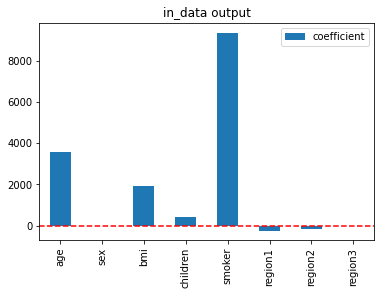

In [29]:
indata=pd.DataFrame(mod1.coef_,index=["age","sex","bmi","children","smoker","region1","region2","region3"],columns=["coefficient"])
indata.plot(kind="bar",title="in_data output")
plt.axhline(y=0,color="red",linestyle="--")

# 7.) Interpret the coefficients

In Sample

The coefficient of age is 3580.36, which means that when age increases by 1, the charge will increase by about 3580.36 when holding other variables constant.

The coefficient of sex is 0, which means gender has no influence on insurance charging.

The coefficient of bmi is 1897.43, which means that when bim increases by 1, the charge will increase by about 1897.43 when holding other variables constant.

The coefficient of children is 415.07, which means that when children increases by 1, the charge will increase by about 415.07 when holding other variables constant.

The coefficient of smoker is 9345.1, which means that smokers will be charged higher than non-smokers with about 9345.1.

The coefficient of the different regions represent the difference in charges between them and the baseline(southwest).




# 8.) Compare in and out of sample MSE’s

In [30]:
import sklearn as sk

In [31]:
sk.metrics.mean_squared_error(in_target,mod1.predict(in_data_scale))

36521811.462161295

In [33]:
mod2=Lasso(alpha=a_in).fit(out_data_scale,out_target)
sk.metrics.mean_squared_error(out_target,mod2.predict(out_data_scale))

36528368.74917457